<a href="https://colab.research.google.com/github/duongphannamhung/Portfolio/blob/main/Segment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import csv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree
from datetime import datetime,date
from kneed import KneeLocator
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
from plotly.offline import iplot
import warnings
warnings.filterwarnings("ignore")

# **I. Import dữ liệu và preprocessing**

Sau khi đã xử lý dữ liệu từ bộ master data, để có được data tính ra điểm của R, F, M , D: rfmd_database_final.csv.

Trong đó:

        R (Recency) là lần mua hàng gần nhất.

        F (Frequency) là tần suất mua hàng trong một năm của từng khách hàng.

        M (Monetary) là doanh thu theo mỗi id khách hàng mang lại.

        D (Discount) là % giảm giá trên Monetary của từng id khách hàng.

Nhóm quyết định chọn thêm yếu tố D, vì xét thấy fashion retailer này có chiến lược giảm giá lớn, là một yếu tố ảnh hưởng đến khả năng mua hàng của người end-users.

In [ ]:
segment_2 = pd.read_csv("vip_seg2_0309_21h29.csv")

In [ ]:
segment_2

,Unnamed: 0,anonymous_id,R,F,M,D,M1_x,Cluster_Id,Category,Percent_color
0,0,1sq33LYIKEVf97ZyucyGOtQclWF,0.548105,2,0.96550,18,0.482750,3,1.0,-
1,1,1tPTUwuJRsecSA8ODfTyzuWoPFK,2.211605,2,1.36200,30,0.681000,3,3.0,50.00
2,2,1tPYlKb51rOp0QGWuBdS71h0ibV,6.185446,2,1.58100,4,0.790500,0,1.0,-
3,3,1tkPK0Tg5IsJHBxuwNTairEWeja,3.554125,4,1.11150,49,0.277875,2,1.0,100.00
4,4,1uceNzqLHAqWa5YBc3L6r0ZIUpr,9.678644,2,2.02500,9,1.012500,0,4.0,40.00
...,...,...,...,...,...,...,...,...,...,...
49761,49761,1uggrE98GDqCdIffKFLCZ0Y45u1,4.412301,2,1.49000,14,0.745000,3,2.0,50.00
49762,49762,1ugjeyddepbrgYE7lwAGSmiLTo1,5.211889,2,1.32050,0,0.660250,3,3.0,-
49763,49763,1ugoRBMinsE1cOWhaXOL9rwrPwS,0.309994,6,3.78275,7,0.630458,2,7.0,18.18
49764,49764,1ugvi6XeNFkwT8dNmL8T5m2enNL,6.446092,1,0.75000,0,0.750000,0,1.0,-


In [ ]:
segment_2 = segment_2[segment_2[' Percent_color '].isnull()==False]

In [ ]:
segment_2 = segment_2[(segment_2['Cluster_Id']==2)|(segment_2['Cluster_Id']==4)]

In [ ]:
segment_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8954 entries, 3 to 49763
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       8954 non-null   int64  
 1   anonymous_id     8954 non-null   object 
 2   R                8954 non-null   float64
 3   F                8954 non-null   int64  
 4   M                8954 non-null   float64
 5   D                8954 non-null   int64  
 6   M1_x             8954 non-null   float64
 7   Cluster_Id       8954 non-null   int64  
 8   Category         8954 non-null   float64
 9    Percent_color   8954 non-null   object 
dtypes: float64(4), int64(4), object(2)
memory usage: 769.5+ KB


In [ ]:
segment_2.columns = ['Unnamed: 0', 'anonymous_id', 'R', 'F', 'M', 'D', 'M1', 'Cluster_Id',
       'diversity', 'outstanding']

In [ ]:
segment_2 = segment_2[['anonymous_id', 'R', 'F', 'M1', 'D', 'Cluster_Id',
       'diversity','outstanding']]

In [ ]:
segment_2 = segment_2.reset_index(drop=True)

In [ ]:
for i in range(len(segment_2['outstanding'])):
    if segment_2['outstanding'][i] == ' -   ':
        segment_2['outstanding'][i] = ' 0 '

In [ ]:
for i in range(len(segment_2['outstanding'])):
    segment_2['outstanding'][i] = segment_2['outstanding'][i].strip()

In [ ]:
segment_2['outstanding'] = segment_2['outstanding'].astype("float")

In [ ]:
segment_2.describe()

,R,F,M1,D,Cluster_Id,diversity,outstanding
count,8954.000000,8954.000000,8954.000000,8954.000000,8954.000000,8954.000000,8954.000000
mean,4.634944,3.026915,1.681913,13.444941,2.785347,4.598839,30.918428
std,2.637393,1.758149,1.105454,12.729534,0.976745,2.416875,24.924041
min,0.002766,1.000000,0.058000,0.000000,2.000000,1.000000,0.000000
25%,2.541354,1.000000,0.767504,5.000000,2.000000,3.000000,12.500000
50%,4.745359,3.000000,1.357687,10.000000,2.000000,4.000000,28.570000
75%,6.654680,4.000000,2.344906,20.000000,4.000000,6.000000,45.450000
max,12.119976,8.000000,5.393000,71.000000,4.000000,19.000000,100.000000


In [ ]:
segment_2['outstanding'].unique()

array([100.  ,  40.  ,  18.75,  66.67,   7.14,  27.27,  37.5 ,  28.57,
         0.  ,  16.67,  60.  ,  25.  ,  20.  ,  14.29,  30.  ,  15.38,
        29.41,  15.79,  50.  ,  26.67,  29.63,  53.85,  18.18,  36.36,
        75.  ,  51.85,  33.33,  12.5 ,  22.22,  19.23,  45.45,  21.43,
        35.71,  46.15,  41.67,  58.33,  23.08,  38.89,  11.11,  26.09,
        62.5 ,  10.  ,  87.5 ,  55.  ,  71.43,  15.  ,   7.69,  11.76,
        76.92,  44.44,   9.09,  57.14,  26.32,  70.  ,  42.86,  13.33,
        36.84,  23.53,  63.16,  47.06,  15.15,  31.58,  52.38,  27.59,
        30.77,  41.18,  38.46,  63.64,  80.  ,   6.67,   4.  ,  81.82,
        17.65,  42.11,  17.39,  46.67,  26.92,  47.83,  35.29,  38.1 ,
        32.  ,   5.88,   6.25,  85.71,  83.33,  57.89,  84.62,  77.78,
        69.23,  55.56,  88.89,  53.33,  72.73,   5.56,  18.52,  35.  ,
        30.3 ,  73.33,  54.55,  12.82,  22.73,  27.78,  15.63,  31.25,
        30.43,  39.39,  17.86,   8.33,  13.89,  28.  ,   5.26,  21.05,
      

In [ ]:
segment_2 = segment_2[(segment_2['Cluster_Id']==2)|(segment_2['Cluster_Id']==4)]

,anonymous_id,R,F,M1,D,Cluster_Id,diversity,outstanding
55,1uceQrGHM33D6Z8ZnwaFnXHsjMe,7.110406,3,0.422917,8,2,3.0,66.666667
78,1uceS78dEJcg3T0EgSAa3X8aVZw,7.078973,3,0.733167,28,2,7.0,37.500000
88,1uceSU6C9yTOSeu3K8voDDvRbAc,11.174346,5,0.319000,46,2,2.0,40.000000
91,1uceSm3mrtVxen1W8j4l4OWoHYQ,10.376704,4,0.487875,5,2,4.0,25.000000
93,1uceSwh8jmwlBkbUB8L6WvbGZBm,4.640254,3,0.753333,0,2,6.0,14.285714
...,...,...,...,...,...,...,...,...
49689,1ugSjTbR7ndqfa0GhMggBXupZCr,0.121588,3,0.523333,0,2,4.0,66.666667
49701,1ugU4GbZUU8nsoPn2QVXlSXSqOg,0.348961,2,2.755000,0,4,5.0,57.142857
49703,1ugU9wfqitX1Yg2RWG9hI8iZkZ3,0.540623,1,2.600000,10,4,2.0,0.000000
49730,1ugVUWtuNoiSsO7gy3OBkhmS0W1,0.408148,1,3.300000,8,4,1.0,0.000000


<Figure size 432x288 with 0 Axes>

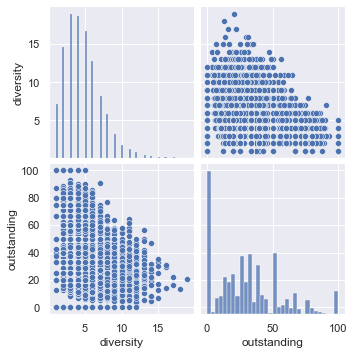

In [ ]:
fig = plt.figure()
fig.patch.set_facecolor('white')
sns.pairplot(segment_2[['diversity','outstanding']])

<AxesSubplot:xlabel='outstanding'>

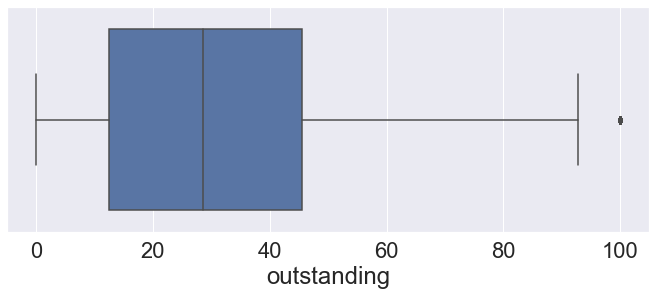

In [ ]:
fig, axs = plt.subplots(figsize=(9, 4), constrained_layout=True)
sns.set(font_scale=2)
# sns.boxplot(data = segment_2,  x = 'diversity',color = 'g')
sns.boxplot(data = segment_2,  x = 'outstanding',color = 'b')

In [ ]:
segment_2

,anonymous_id,R,F,M1,D,Cluster_Id,diversity,outstanding,Cluster_segment2
0,1tkPK0Tg5IsJHBxuwNTairEWeja,3.554125,4,0.277875,49,2,1.0,100.00,0
1,1uceOy0US96gp7G9YREqmk4xMWT,12.118530,1,2.550000,0,4,3.0,40.00,2
2,1ucePU3YSfRQ0MU19vuziCctY1O,8.851543,4,2.037437,7,2,9.0,18.75,1
3,1uceQrGHM33D6Z8ZnwaFnXHsjMe,7.110406,3,0.422917,8,2,3.0,66.67,0
4,1uceRYt8bCZ5GTREFZHmpuWBg8Z,0.038783,4,1.281250,8,2,9.0,7.14,1
...,...,...,...,...,...,...,...,...,...
8949,1ugU4GbZUU8nsoPn2QVXlSXSqOg,0.348961,2,2.755000,0,4,5.0,57.14,0
8950,1ugU9wfqitX1Yg2RWG9hI8iZkZ3,0.540623,1,2.600000,10,4,2.0,0.00,3
8951,1ugVUWtuNoiSsO7gy3OBkhmS0W1,0.408148,1,3.300000,8,4,1.0,0.00,3
8952,1uge057oVIQsEX1iWHS0Gqn5UH7,2.614471,6,1.959750,11,2,5.0,40.00,2


EDA: Continuous

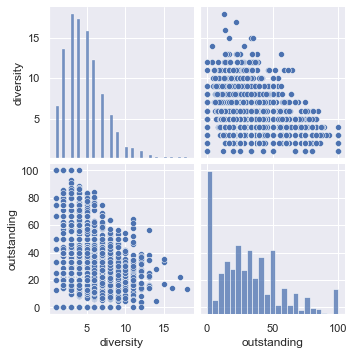

In [ ]:
sns.pairplot(segment_2[['diversity','outstanding']])

<AxesSubplot:>

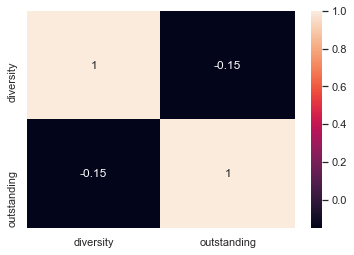

In [ ]:
sns.heatmap(segment_2[['diversity','outstanding']].corr(), annot=True)

# **II. Cluster dựa trên phương pháp K-means**

a. Scale data bằng Standard Scaler:


```
z = (x - m) / s
m: mean của tập training
s: standard deviation của tập training  

```



In [ ]:
scaler = StandardScaler()
segment_scaled = scaler.fit_transform(segment_2[["diversity","outstanding"]])
segment_scaled = pd.DataFrame(segment_scaled)
segment_scaled.columns = ["diversity","outstanding"]
segment_scaled.shape

(8954, 2)

In [ ]:
segment_scaled.head(4)

,diversity,outstanding
0,-1.489129,2.771839
1,-0.661568,0.364390
2,1.821115,-0.488248
3,-0.661568,1.434501


b. Chạy model:

In [ ]:
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8,9,10]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, init='k-means++', max_iter = 300, n_init = 10)
    kmeans.fit(segment_scaled)
    
    ssd.append(kmeans.inertia_)

`Define number of clusters following kmeans.inertia_ (sum of squared distances of samples to their closest cluster center)`

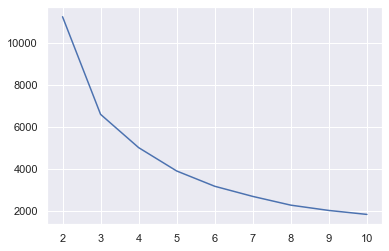

In [ ]:
fig, ax = plt.subplots()
ax.set_xticklabels([1,2,3,4,5,6,7,8,9,10])
plt.plot(ssd)

In [ ]:
kl = KneeLocator(range(2, 11), ssd, curve="convex", direction="decreasing")
print('K-mean Elbow: {}'.format(kl.elbow))

K-mean Elbow: 4




```
Define number of clusters following silhouette_score
```



In [ ]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8,9,10]

for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters,  init='k-means++', max_iter = 100, n_init = 10)
    kmeans.fit(segment_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(segment_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.3630651329060064
For n_clusters=3, the silhouette score is 0.40864185347284954
For n_clusters=4, the silhouette score is 0.3882321531749055
For n_clusters=5, the silhouette score is 0.3837879356874056
For n_clusters=6, the silhouette score is 0.4003649526285497
For n_clusters=7, the silhouette score is 0.4082576536910596
For n_clusters=8, the silhouette score is 0.3961110107180064
For n_clusters=9, the silhouette score is 0.4026992034371702
For n_clusters=10, the silhouette score is 0.39496831771284074


Dựa theo kmeans.inertia_, số cluster tối ưu là 5.

Dựa theo silhouette score, số cluster tối ưu là 5.

--> Sẽ phân chia thành 5 cluster.

Tối ưu hóa các chỉ số max_iter, n_init: 

    MAX_ITER

In [ ]:
range_max_iter = [100, 200, 300, 400, 500, 600, 700]

for max_iter_ in range_max_iter:
    kmeans = KMeans(n_clusters=5,  init='k-means++', max_iter = max_iter_, n_init = 10, random_state= 32)
    kmeans.fit(rfm_df_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For max_iter={0}, the silhouette score is {1}".format(max_iter_, silhouette_avg))

--> max_iter = 100 là tối ưu

    N_INIT

In [ ]:
range_n_init = [10, 20, 30, 40, 60, 80, 300]

for n_init_ in range_n_init:
    kmeans = KMeans(n_clusters=5,  init='k-means++' , max_iter = 300, n_init = n_init_, random_state= 32)
    kmeans.fit(rfm_df_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_init={0}, the silhouette score is {1}".format(n_init_, silhouette_avg))

n_init = 10 là tối ưu

Với 5 clusters:

In [ ]:
kmeans = KMeans(n_clusters=4, max_iter=100, n_init= 10, init='k-means++', random_state = 32)
kmeans.fit(segment_scaled)

KMeans(max_iter=100, n_clusters=4, random_state=32)

In [ ]:
segment_scaled

,diversity,outstanding
0,-1.489129,2.771839
1,-0.661568,0.364390
2,1.821115,-0.488248
3,-0.661568,1.434501
4,1.821115,-0.954089
...,...,...
8949,0.165993,1.052118
8950,-1.075349,-1.240575
8951,-1.489129,-1.240575
8952,0.165993,0.364390


In [ ]:
segment_scaled['Cluster_segment2'] = kmeans.labels_
# Trung bình doanh thu trên từng ID của mỗi nhóm.
# (segment_2.groupby(['Cluster_segment2']).M.mean())

In [ ]:
segment_2['Cluster_segment2'] = segment_scaled['Cluster_segment2']

<AxesSubplot:xlabel='Cluster_segment2', ylabel='outstanding'>

<Figure size 432x288 with 0 Axes>

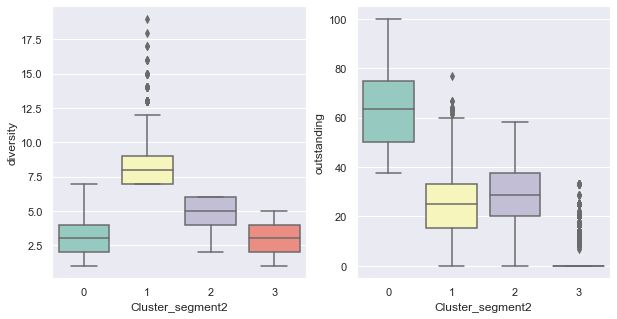

In [ ]:
fig = plt.figure()
fig.patch.set_facecolor('white')
fig, axs = plt.subplots(ncols=2,nrows=1, figsize = (10,5))
sns.set_theme(style="darkgrid")
sns.boxplot(x='Cluster_segment2', y='diversity', palette='Set3',data=segment_2, ax=axs[0])
sns.boxplot(x='Cluster_segment2', y='outstanding',palette='Set3', data=segment_2,ax=axs[1])

Dicussion: 

Nhóm 0: Đa dạng loại sản phẩm, tông màu nổi bật khoảng 25%.
Nhóm 1: Độ nổi của màu sắc và độ đa dạng giỏ đồ ở mức trung bình. 
Nhóm 2: Gu hàng basic, giỏ hàng tương đối ít.
Nhóm 3: Khác hàng thích màu nổi , độ đa dạng giỏ hàng thấp nhất.

Visualize Cluster:

<Figure size 432x288 with 0 Axes>

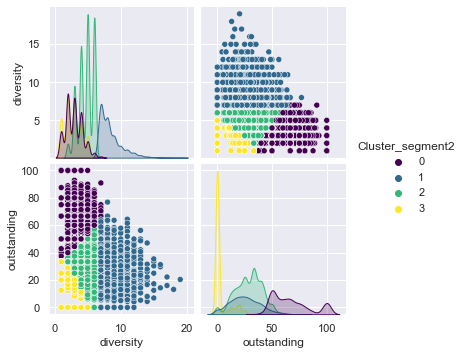

In [ ]:
fig = plt.figure()
fig.patch.set_facecolor('white')
sns.pairplot(segment_2[['diversity','outstanding','Cluster_segment2']],hue='Cluster_segment2',palette="viridis")

In [ ]:
segment_2.to_csv('0309_10h37_segment2.csv')